# MULTIVARIATE TIME SERIES ANALYSIS

### SHORT TERM PREDICTION USING LSTM RECURRENT NETWORKS

Current wind speed is predicted with the previous one hour's data given as input

In [1]:
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


### IMPORTING DATA

In [2]:
#One year data
data = pd.read_csv('D://T1.csv',parse_dates=True,index_col='Date/Time')
data=data.drop(['Theoretical_Power_Curve (KWh)'], axis = 1)

In [3]:
#Since Each day has 144 timestamps, 52560 entries must be present in the data
len(data)

50530

In [4]:
#52560-50530

## FILLING MISSING TIME STAMPS USING FORWARD AND BACKWARD FILL

In [5]:
data=data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='10T'))

In [6]:
data = data.ffill().bfill()

In [7]:
len(data)

52560

In [8]:
data.head()

,Wind Speed (m/s),LV ActivePower (kW),Wind Direction (°)
2018-01-01 00:00:00,5.311336,380.047790,259.994904
2018-01-01 00:10:00,5.672167,453.769196,268.641113
2018-01-01 00:20:00,5.216037,306.376587,272.564789
2018-01-01 00:30:00,5.659674,419.645904,271.258087
2018-01-01 00:40:00,5.577941,380.650696,265.674286


### NORMALIZING THE FEATURES USING SKLEARN

In [9]:
# normalize features in the range 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

In [10]:
scaled.shape

(52560, 3)

In [11]:
type(scaled)

numpy.ndarray

### CONVERTING THE NORMALIZED NUMPY ARRAY INTO  SUPERVISED LEARNING 

In [12]:
# specify the number of lag hours
#For one hour there are 6 entries.Previous 6 entries for each feature is calculated here using the function series_to_supervised
n_hours = 6
n_features = 3

In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.shape

(52554, 21)

In [15]:
reframed.head()

,var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),var2(t-4),var3(t-4),var1(t-3),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
6,0.210717,0.105633,0.722213,0.225032,0.125991,0.746230,0.206936,0.085289,0.757129,0.224537,...,0.753500,0.221294,0.105800,0.737989,0.222330,0.111804,0.734946,0.229826,0.124289,0.739348
7,0.225032,0.125991,0.746230,0.206936,0.085289,0.757129,0.224537,0.116568,0.753500,0.221294,...,0.737989,0.222330,0.111804,0.734946,0.229826,0.124289,0.739348,0.210507,0.107620,0.716531
8,0.206936,0.085289,0.757129,0.224537,0.116568,0.753500,0.221294,0.105800,0.737989,0.222330,...,0.734946,0.229826,0.124289,0.739348,0.210507,0.107620,0.716531,0.221559,0.128720,0.704118
9,0.224537,0.116568,0.753500,0.221294,0.105800,0.737989,0.222330,0.111804,0.734946,0.229826,...,0.739348,0.210507,0.107620,0.716531,0.221559,0.128720,0.704118,0.219123,0.122113,0.718682
10,0.221294,0.105800,0.737989,0.222330,0.111804,0.734946,0.229826,0.124289,0.739348,0.210507,...,0.716531,0.221559,0.128720,0.704118,0.219123,0.122113,0.718682,0.227093,0.138256,0.699591


### SPLITTING INTO TRAIN DATA AND TEST DATA

Here January to August is taken for training and the remaining for testing

In [16]:
# split into train and test sets
values = reframed.values
n_train_time = 34992
train = values[:n_train_time, :]
test = values[n_train_time:, :]


In [17]:
test.shape,train.shape

((17562, 21), (34992, 21))

In [18]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]




In [19]:
train_X.shape, len(train_X), train_y.shape,test_X.shape

((34992, 18), 34992, (34992,), (17562, 18))

### RESAMPLING THE INPUTS INTO 3-DIMENSION

In [20]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [21]:
train_X.shape, train_y.shape, test_X.shape,test_y.shape

((34992, 6, 3), (34992,), (17562, 6, 3), (17562,))

### DESIGNING STACKED LSTM MODEL

In [22]:
# design network
model = Sequential()
model.add(LSTM(6, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(6,activation='relu',return_sequences=True))
#model.add(LSTM(24,activation='sigmoid', return_sequences=True))
#keras.layers.Dropout(0.01)
#model.add(LSTM(24,activation='sigmoid', return_sequences=True))
model.add(LSTM(6,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=sgd)

model.compile(loss='mean_squared_error', optimizer='adam')

W0330 18:54:04.364290 13992 deprecation_wrapper.py:119] From C:\ProgramData\Anacondaa3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0330 18:54:05.652675 13992 deprecation_wrapper.py:119] From C:\ProgramData\Anacondaa3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0330 18:54:05.749768 13992 deprecation_wrapper.py:119] From C:\ProgramData\Anacondaa3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0330 18:54:07.068628 13992 deprecation_wrapper.py:119] From C:\ProgramData\Anacondaa3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [23]:
 #fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)


W0330 18:54:07.626136 13992 deprecation.py:323] From C:\Users\Home\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0330 18:54:09.511090 13992 deprecation_wrapper.py:119] From C:\ProgramData\Anacondaa3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0330 18:54:09.636789 13992 deprecation_wrapper.py:119] From C:\ProgramData\Anacondaa3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 34992 samples, validate on 17562 samples
Epoch 1/150
 - 9s - loss: 0.0211 - val_loss: 0.0063
Epoch 2/150
 - 6s - loss: 0.0065 - val_loss: 0.0040
Epoch 3/150
 - 6s - loss: 0.0045 - val_loss: 0.0034
Epoch 4/150
 - 6s - loss: 0.0037 - val_loss: 0.0029
Epoch 5/150
 - 6s - loss: 0.0034 - val_loss: 0.0027
Epoch 6/150
 - 6s - loss: 0.0031 - val_loss: 0.0025
Epoch 7/150
 - 6s - loss: 0.0029 - val_loss: 0.0023
Epoch 8/150
 - 7s - loss: 0.0027 - val_loss: 0.0021
Epoch 9/150
 - 6s - loss: 0.0025 - val_loss: 0.0019
Epoch 10/150
 - 6s - loss: 0.0022 - val_loss: 0.0016
Epoch 11/150
 - 6s - loss: 0.0020 - val_loss: 0.0014
Epoch 12/150
 - 6s - loss: 0.0017 - val_loss: 0.0012
Epoch 13/150
 - 6s - loss: 0.0015 - val_loss: 0.0011
Epoch 14/150
 - 6s - loss: 0.0014 - val_loss: 0.0011
Epoch 15/150
 - 6s - loss: 0.0013 - val_loss: 0.0010
Epoch 16/150
 - 6s - loss: 0.0013 - val_loss: 0.0010
Epoch 17/150
 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch 18/150
 - 7s - loss: 0.0012 - val_loss: 0.0010
Epoch

In [24]:
from pylab import rcParams
rcParams['figure.figsize']=20,7

#### TRAIN LOSS Vs VALIDATION LOSS

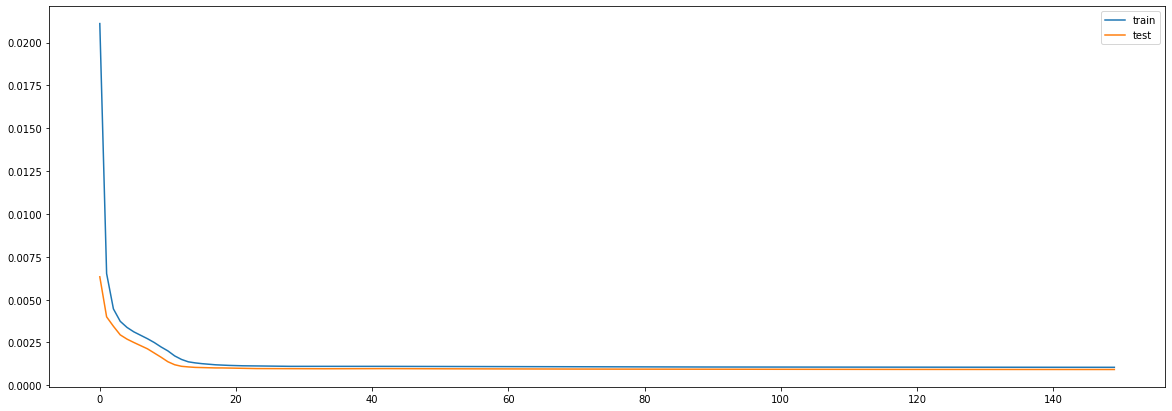

In [25]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


## Making Predictions

In [26]:
# make a prediction
pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))


In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 6)              240       
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 6)              312       
_________________________________________________________________
lstm_3 (LSTM)                (None, 6)                 312       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 871
Trainable params: 871
Non-trainable params: 0
_________________________________________________________________


### INVERSING THE SCALING AND NORMALIZATION USING SKLEARN

In [28]:
# invert scaling for forecast
inv_pred = concatenate((pred, test_X[:, -2:]), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:,0]


In [29]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -2:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [30]:
inv_y = inv_y[:-1]
inv_pred = inv_pred[1:]

## CREATING A DATA FRAME WITH ACTUAL AND PREDICTED VALUES 

In [31]:
#rmse = sqrt(mean_squared_error(inv_y[:-1,], inv_yhat[1:,]))
#print('Test RMSE: %.3f' % rmse)

In [32]:
c=pd.date_range('9/1/2018 01:00:00',periods=17562,freq='10T')
c=pd.DataFrame(c,columns=['index'])
actual_data=pd.DataFrame(inv_y,columns=['actual'])
pred_data=pd.DataFrame(inv_pred,columns=['pred'])
c['actual']=actual_data['actual']
c['pred']=pred_data['pred']

In [33]:
c=c.set_index('index')
c = c.ffill().bfill()

In [34]:
c.head()

,actual,pred
index,,
2018-09-01 01:00:00,4.981733,4.981697
2018-09-01 01:10:00,5.473280,5.472966
2018-09-01 01:20:00,5.571076,5.499430
2018-09-01 01:30:00,5.696821,5.636166
2018-09-01 01:40:00,5.657978,5.599826


### CALCULATING RMSE AND MAE

In [35]:
import math
train_score = model.evaluate(train_X, train_y, verbose=0)
print('Train RMSE:{:.2f} '.format(math.sqrt(train_score)))


Train RMSE:0.03 


In [36]:
# calculate RMSE
mse = mean_squared_error(inv_y, inv_pred)
rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % mse)

Test RMSE: 0.151
Test MSE: 0.023


In [37]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(inv_y,inv_pred)
rmae=sqrt(mean_absolute_error(inv_y,inv_pred))
print('Test MAE: %.3f' % mae)
print('Test RMAE: %.3f' % rmae)

Test MAE: 0.097
Test RMAE: 0.312


###  PLOTTING

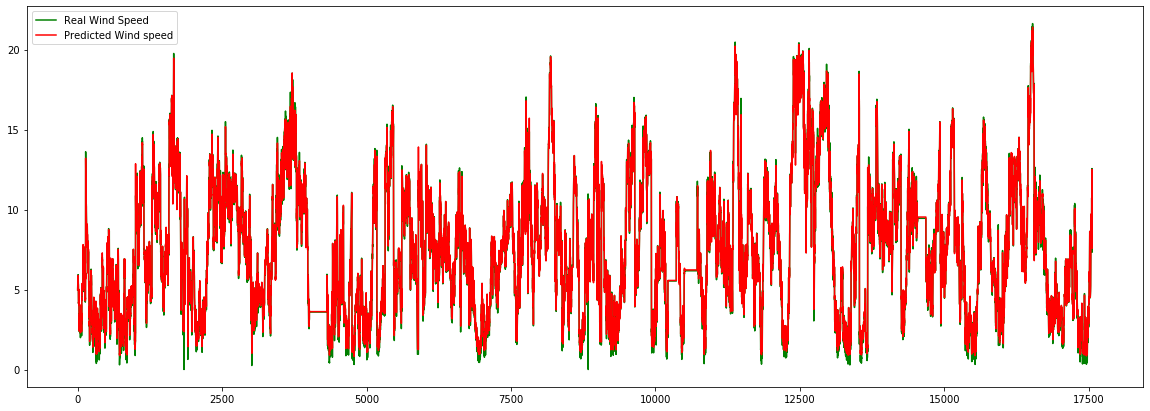

In [38]:
pyplot.plot(inv_y, color='green', label = 'Real Wind Speed')
pyplot.plot(inv_pred, color='red', label = 'Predicted Wind speed')
pyplot.legend()
pyplot.show()

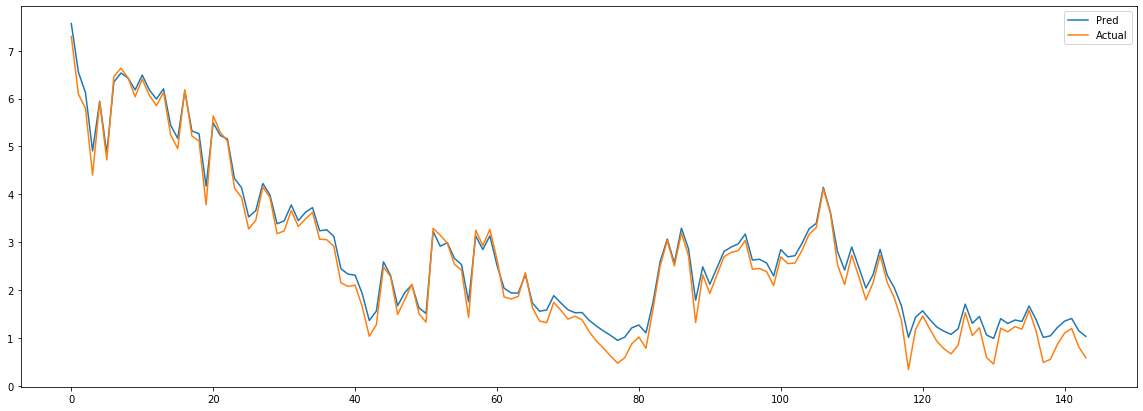

In [39]:
##plotting last day in the test set(31st Dec)
pyplot.plot(list(range(len(c['pred']['2018-12-30']))),c['pred']['2018-12-30'], label='Pred ')
pyplot.plot(list(range(len(c['pred']['2018-12-30']))),c['actual']['2018-12-30'], label='Actual')
pyplot.legend()
pyplot.show()
